In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Pandey@12345',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Asus/Desktop/Pyhton and SQL project/Sales Data'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector 

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Pandey@12345',
    database='ecommerce'
)

cur = db.cursor()

# 1. List all unique cities where customers are located.

In [ ]:
query = """ select distinct customer_city from customers """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.


In [63]:
query = """ Select count(order_id)
From orders
Where year(order_purchase_timestamp) = 2017;"""

cur.execute(query)
data = cur.fetchall()

data[0]

(90202,)

# 3. Find the total sales per category.


In [43]:
query  = """ Select products.product_category as category, round(sum(payments.payment_value),1) as total_sales
from products
join order_items on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id
Group by category;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,perfumery,1013477.3
1,Furniture Decoration,2860352.8
2,telephony,973764.1
3,Fashion Bags and Accessories,436316.6
4,bed table bath,3425107.3
...,...,...
69,cds music dvds,2398.9
70,La Cuisine,5827.1
71,Fashion Children's Clothing,1571.3
72,PC Gamer,4348.9


# 4. Calculate the percentage of orders that were paid in installments.


In [52]:
query = """Select (sum(case when payment_installments >=1 then 1 else 0 end))/count(*) *100
From payments;"""

cur.execute(query)
data = cur.fetchall()

'% of orders paid in installments',data [0][0]

('% of orders paid in installments', Decimal('99.9981'))

# Count the number of customers from each state.

In [71]:
query  = """Select  customer_state, count(customer_id)
From customers
group by customer_state;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["State", "No. of customers"])
df.head()

,State,No. of customers
0,SP,83492
1,SC,7274
2,MG,23270
3,PR,10090
4,RJ,25704


# Calculate the number of orders per month in 2018.

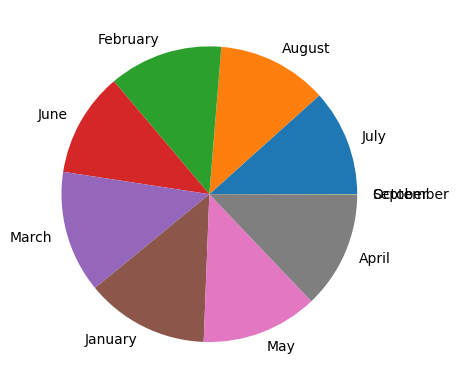

In [50]:
query = """Select count(order_id) as orders, monthname(order_purchase_timestamp) as months
From orders
Where year(order_purchase_timestamp) = 2018
group by months;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Orders", "Months"])
plt.pie(df["Orders"], labels = df["Months"])
plt.show()

# Find the average number of products per order, grouped by customer city.

In [31]:
query = """ SELECT customers.customer_city, AVG(order_item_count.oc) AS average_items_per_order
FROM customers
JOIN (
    SELECT orders.customer_id, COUNT(order_items.order_id) AS oc
    FROM orders
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
) AS order_item_count
ON customers.customer_id = order_item_count.customer_id
GROUP BY customers.customer_city;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["city", "Avg products per order"])
df.head(7)

,city,Avg products per order
0,treze tilias,2.5455
1,indaial,2.2308
2,sao jose dos campos,2.2770
3,sao paulo,2.3124
4,porto alegre,2.3499
5,santos,2.3229
6,sao francisco do sul,2.4706


# Calculate the percentage of total revenue contributed by each product category.

In [44]:
query = """Select 	products.product_category as category, round(sum(payments.payment_value)/(select sum(payment_value)
from payments) * 100,2) as percentage_of_total_revenue
from products
join order_items on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id
Group by category
order by percentage_of_total_revenue Desc ;"""

cur.execute(query)
data = cur.fetchall()

df= pd.DataFrame(data, columns = ["category", "percentage_of_total_revenue"])
df.head(10)

,category,percentage_of_total_revenue
0,bed table bath,21.40
1,HEALTH BEAUTY,20.71
2,computer accessories,19.81
3,Furniture Decoration,17.87
4,Watches present,17.86
5,sport leisure,17.39
6,housewares,13.68
7,automotive,10.65
8,Garden tools,10.47
9,Cool Stuff,9.74
